# NYC Taxis Dataset Analysis for High-Performance Computing subject - Project

## Start Spark, import libraries and read data (Google Colab)

Notice that many of the following commands are mandatory to be able to run PySpark on Google Colab. On local execution they will not be present.

In [1]:
# Starting Spark in Google Colab
# Installing Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Binaries path
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# PySpark and contexts
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext("local", "Taxi Analysis")

# Using local[*] in order to use all the local system cores
spark = pyspark.sql.SparkSession.builder \
                   .master("local[*]") \
                   .appName("Taxi Analysis") \
                   .getOrCreate()

In [ ]:
# Import useful libraries
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import unix_timestamp, substring, mean, asc, dayofweek, count
from itertools import groupby
from functools import reduce

!pip install geopandas
import geopandas as gpd

Three different files will be needed for the project to correctly run:
- The trips dataset from January 2017 : 'tripdata_2017-01.csv' (Provided by the teacher, can be also found at official webpage https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
- The zones and boroughs location IDs name relation : 'taxi+_zone_lookup.csv' (Extracted from official webpage at https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv)
- The geographic information file containing zone boundaries : 'taxi_zones.geojson' (Shapefile extracted from official webpage https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip and transformed into GeoJSON with the WGS84 reference frame containing the latitude and longitude coordinates at https://mygeodata.cloud/converter/shp-to-latlong)

In [ ]:
# Upload needed files
from google.colab import files
files.upload() 

In [ ]:
# Home directory current files
!ls

In [5]:
# Read and preview trip data
df = spark.read.csv('tripdata_2017-01.csv', inferSchema = True, header = True, mode = "DROPMALFORMED")
df.show(10)
df.printSchema()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3|
|       1| 2017-01-09 11:32:27|  2017-01-09 11:3

**Results of execution in http://localhost:4040/jobs/**:

This part involves two jobs and each job has one stage, as shown below:

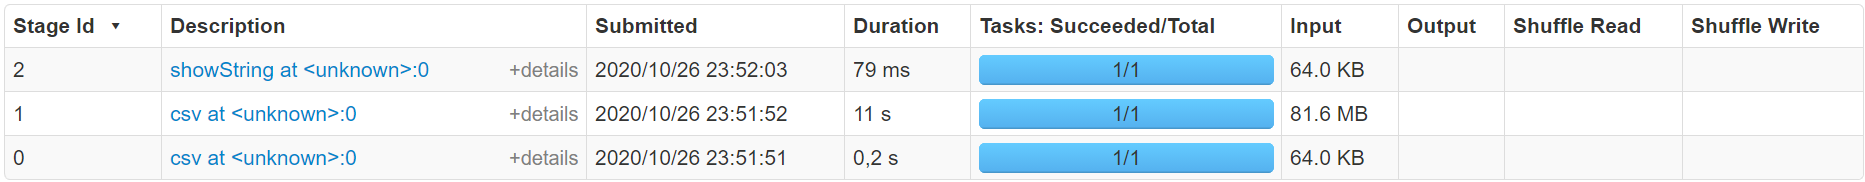


In [6]:
# Read and preview locationIds
df_ids = spark.read.csv('taxi+_zone_lookup.csv', inferSchema = True, header = True, mode = "DROPMALFORMED")
df_ids.show(10)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 10 rows



**Results of execution in http://localhost:4040/jobs/**:

This part involves three jobs and each job has one stage, as shown below:

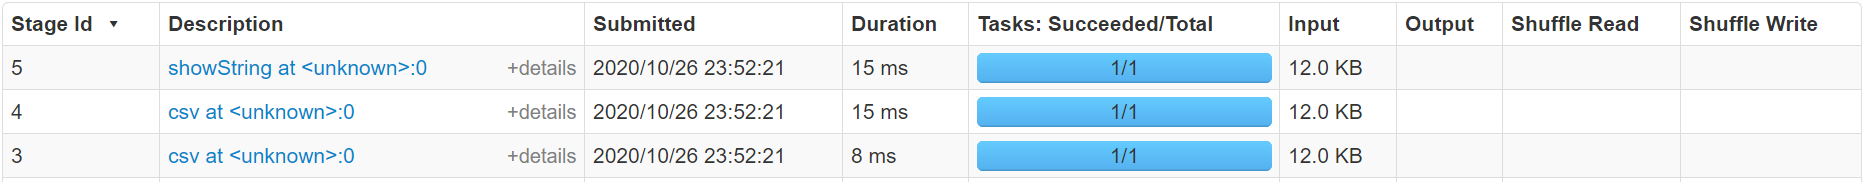

## Cleaning section

Some elements of the dataset do not make real sense. In this section the data will be cleaned as shown below.

In [7]:
# We delete rows with zones 264 and 265 which correspond to UNKNOWN locations
df = df.filter((df.PULocationID != 264) & (df.PULocationID != 265) & 
               (df.DOLocationID != 264) & (df.DOLocationID != 265))

# We delete the rows with negative tips
df = df.filter(df['tip_amount'] >= 0)

# We delete the rows with tips bigger than 100
df = df.filter(df['tip_amount'] <= 100)

# We delete the rows with passenger number 0 or negative
df = df.filter(df['passenger_count'] > 0)

# We delete the rows with distance 0 or negative
df = df.filter(df['trip_distance'] > 0)

# We delete the rows with fare amount 0 or negative
df = df.filter(df['fare_amount'] > 0)

# We delete the rows with fare amount bigger than 400
df = df.filter(df['fare_amount'] < 400)

# We delete the rows with total amount 0 or negative
df = df.filter(df['total_amount'] > 0)

# We delete the rows with total amount bigger than 400
df = df.filter(df['total_amount'] < 400)

# We calculate the trip duration so we can filter durations greater than 3h:
df = df.withColumn("unix_pickup", unix_timestamp(df['tpep_pickup_datetime'],'dd-MMM-yyyy HH:mm:ss')).withColumn("unix_dropoff",unix_timestamp(df['tpep_dropoff_datetime'],'dd-MMM-yyyy HH:mm:ss'))
df = df.withColumn('time_min', ( (df['unix_dropoff'] - df['unix_pickup']) /60 ))

# We delete the rows with duration 0 or negative
df = df.filter(df['time_min'] > 0)

# We delete the rows with duration greater than 3h
df = df.filter(df['time_min'] < 3*60)

## Getting familiar with the NYC map

This section introduces the initial aspect of the geographical area on which the data obtained are related. First of all, a table is created by districts in which the aspects that delimit these regions are shown.

After that, four maps are displayed, indicating the general appearance, the districts, the Zone ID and Zone ID emphasizing the Manhattan area.

In [8]:
df_places = gpd.read_file('taxi_zones.geojson')
df_places

# By Boroughs
df_places['unique_id'] = df_places.groupby(['borough']).ngroup()
df_places['unique_id'].value_counts()

first_values = df_places.groupby(['borough']).first()
first_values = first_values.reset_index()
first_values.head(5)

,borough,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,geometry,unique_id
0,Bronx,3,0.084341,0.000314,Allerton/Pelham Gardens,3,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",0
1,Brooklyn,11,0.079211,0.000265,Bath Beach,11,"POLYGON ((-74.00110 40.60303, -74.00032 40.602...",1
2,EWR,1,0.116357,0.000782,Newark Airport,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",2
3,Manhattan,4,0.043567,0.000112,Alphabet City,4,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",3
4,Queens,2,0.433470,0.004866,Jamaica Bay,2,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



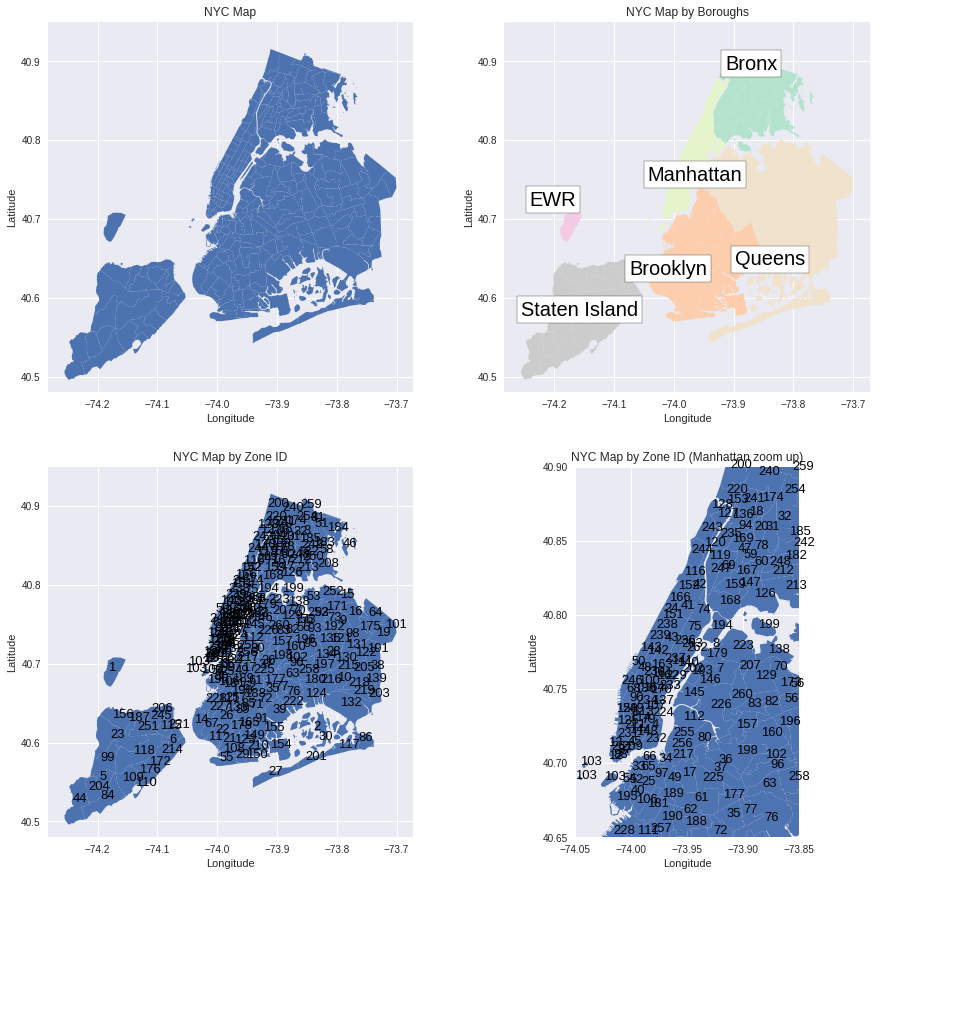

In [9]:
# All plots together
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = plt.subplot(2, 2, 1)
ax = df_places.plot(ax=ax)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('NYC Map')

ax = plt.subplot(2, 2, 2)
ax = df_places.plot(column='unique_id', cmap='Pastel2', ax=ax)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('NYC Map by Boroughs')

for x, y, label in zip(first_values.geometry.centroid.x, first_values.geometry.centroid.y, first_values.borough):
    ax.annotate(label, xy=(x, y), xytext = (-40, 20), textcoords= 'offset points', fontsize=20, color='black', bbox=dict(facecolor='white', edgecolor='black'))

ax = plt.subplot(2, 2, 3)
ax = df_places.plot(ax=ax)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('NYC Map by Zone ID')

for x, y, label in zip(df_places.geometry.centroid.x, df_places.geometry.centroid.y, df_places.LocationID):
    ax.annotate(label, xy=(x, y), xytext = (-5, 0), textcoords= 'offset points', fontsize=13, color='black')

ax = plt.subplot(2, 2, 4)
ax = df_places.plot(alpha=3, ax=ax)
ax.set_xlim([  -74.05, -73.85])
ax.set_ylim([40.65, 40.9])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('NYC Map by Zone ID (Manhattan zoom up)')

for x, y, label in zip(df_places.geometry.centroid.x, df_places.geometry.centroid.y, df_places.LocationID):
    ax.annotate(label, xy=(x, y), xytext = (-5, 0), textcoords= 'offset points', fontsize=13, color='black')

plt.show()

## Correlation matrix for relevant attributes

This section shows the steps necessary to generate a correlation matrix between the variables of greatest interest. It has been preferred to represent a lower triangular matrix (through the mask parameter) to simplify the understanding of the graph.

Apart from the evident correlation between tips and the payment method (since only tips made by credit card are considered), a positive correlation can be seen between the pick-up and drop-off areas, and between the travel time and tips.

In [10]:
# Get relevant attributes from original dataframe

df_intermediate=df.select(df['tpep_pickup_datetime'].alias('pickup_date'), 
                         df['tpep_dropoff_datetime'].alias('dropoff_date'), 
                         df['passenger_count'].alias('passengers'), 
                         (df['trip_distance']*1.60934).alias('distance_km'),
                         df['PULocationID'].alias('Pick_up_ID'), 
                         df['DOLocationID'].alias('Drop_off_ID'), 
                         df['payment_type'].alias('payment'),
                         df['tip_amount'].alias('tip_dollars'),
                         df['total_amount'].alias('journey_price'),
                         df['time_min'].alias('time_min'))

# Get attributes for correlation heatmap

df_correlation=df_intermediate.select(df_intermediate['passengers'], df_intermediate['Pick_up_ID'],
                                      df_intermediate['Drop_off_ID'], df_intermediate['time_min'],
                                      df_intermediate['tip_dollars'], df_intermediate['journey_price'],
                                      df_intermediate['payment'], df_intermediate['distance_km'])

In [11]:
# Correlation matrix

columns = ['passengers', 'Pick_up_ID', 'Drop_off_ID', 
          'time_min', 'tip_dollars', 'journey_price', 'payment', 'distance_km']

vector_col = "corr_features"

assembler = VectorAssembler(inputCols=['passengers', 'Pick_up_ID', 'Drop_off_ID', 
                                       'time_min', 'tip_dollars', 'journey_price',
                                       'payment', 'distance_km'], 
                            outputCol=vector_col)

corr_vector = assembler.transform(df_correlation).select(vector_col)
matrix = Correlation.corr(corr_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist()
df_corr = spark.createDataFrame(corr_matrix,columns)

**Results of execution in http://localhost:4040/jobs/**:

This part involves three jobs and each job has one stage, as shown below:

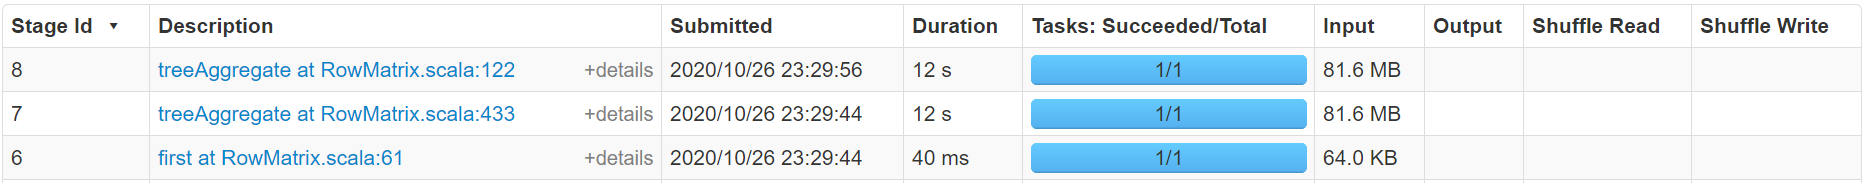

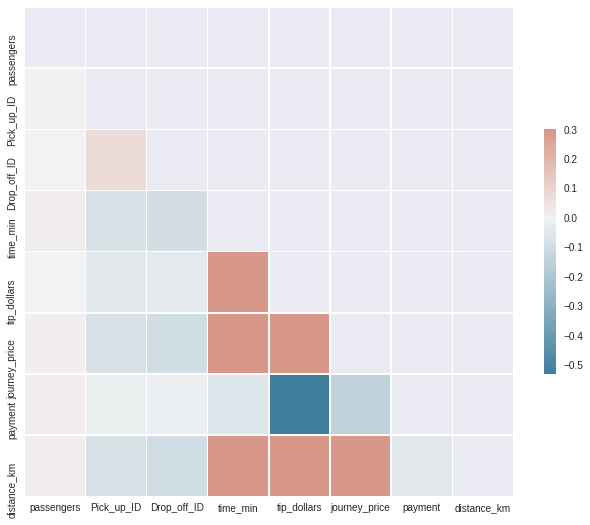

In [12]:
# Plot a triangular correlation matrix

mask = np.triu(np.ones_like(corr_matrix))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            xticklabels=columns, yticklabels=columns)

## Number of trips per weekday with Map-Reduce word-count approach
A trip is considered that took place in a weekday when it started on that day. Firstly, we select the variables of interest, transform  the pick-up date to format (1 to 7 where 1 refers to Sunday and 7 to Saturday).

The result obtained shows how the dataset has been trimmed since there are almost no trips from Wednesday to Friday. 

Finally, we implement the map - shuffle - reduce. In the reduce part, we group by key as (key, groups) and then for each couple, yield (key, reduce)with reduce(function, last entry of each groups)).

In [13]:
df_weekday=df_intermediate.select(df_intermediate['pickup_date'])

df1 = df_weekday.withColumn('Week day', dayofweek(df_weekday.pickup_date))
days = df1.select('Week day').rdd.flatMap(lambda y: y).collect()

# Map
mapping = map((lambda y : (y, 1)), days)

# Shuffle
sorted_map = sorted(mapping)

# Reduce: 
groups = groupby(sorted_map, lambda s:s[0])
result = map(lambda lam: (lam[0], reduce(lambda y, z: y + z, map(lambda s:s[1], lam[1]))), groups)
data_days=list(result)

**Results of execution in http://localhost:4040/jobs/**:

This part involves one job with one stage, as shown below:

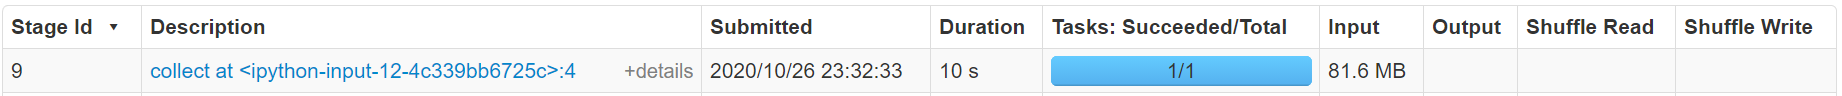

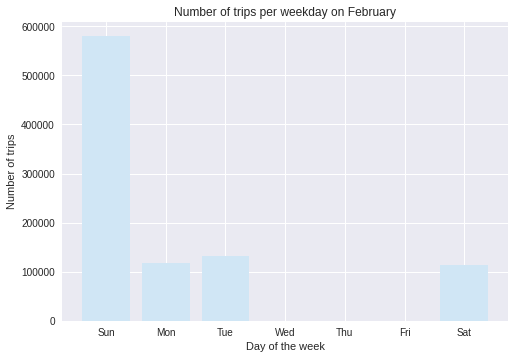

In [14]:
# Barplot: Number of trips per weekday on February
fig, ax = plt.subplots()
ax.bar(range(len(data_days)), [t[1] for t in data_days]  , align="center", color='#d0e6f5')
ax.set_xticks(range(len(data_days)))
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],)
ax.set_title('Number of trips per weekday on February')
ax.set_ylabel('Number of trips')
ax.set_xlabel('Day of the week')
plt.show()

## Financial records
Obtain the summary statistics of the relevant variables and then, carry out some queries in order to obtain the five highest values of number of passengers, trip duration, trip distance, amount of tips and final price of the trip.

This section aims to show how the variables are after having carried out a cleanup under logical criteria.

In [15]:
df_correlation.summary().show()

+-------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+
|summary|        passengers|        Pick_up_ID|       Drop_off_ID|            time_min|       tip_dollars|     journey_price|            payment|       distance_km|
+-------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+
|  count|            944024|            944024|            944024|              944024|            944024|            944024|             944024|            944024|
|   mean|1.6901244036168572|158.55973682872468|156.57479047142868|  12.577060240699701| 1.658122060456221|15.301150013243667| 1.3679133157631587| 4.866486356633007|
| stddev|1.2966439005756787| 67.07536682409241| 71.46318559167304|   9.507674541012998|2.3074541507151705|12.584860169307124|0.49770449523187793|5.9501191605374215|
|    min| 

**Results of execution in http://localhost:4040/jobs/**:

This part involves one job with two stages, as shown below:

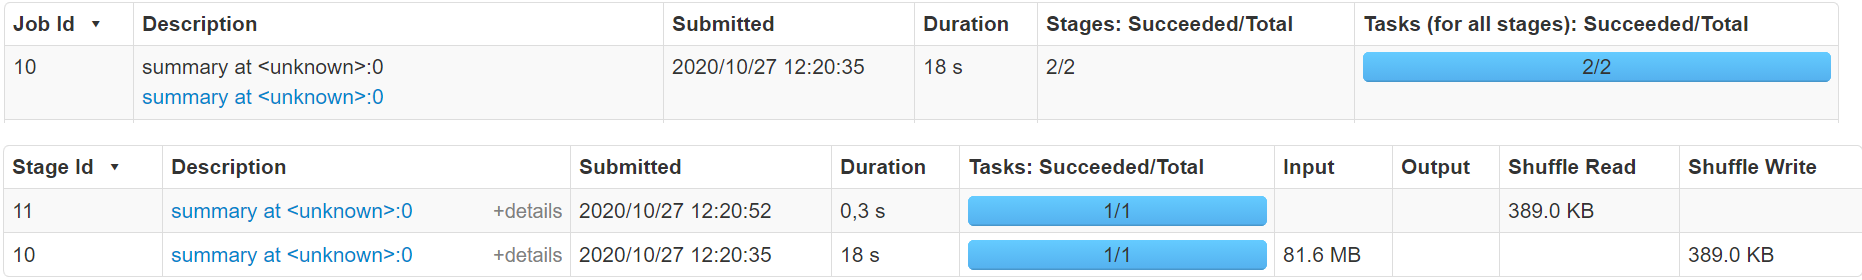

In [16]:
# Temporal View for working with SQL
df_correlation.createOrReplaceTempView("Records")

query1 = """
SELECT DISTINCT passengers FROM Records ORDER BY passengers DESC LIMIT 5
"""
query2 = """
SELECT DISTINCT distance_km FROM Records ORDER BY distance_km DESC LIMIT 5
"""
query3 = """
SELECT DISTINCT time_min FROM Records ORDER BY time_min DESC LIMIT 5
"""
query4 = """
SELECT DISTINCT tip_dollars FROM Records ORDER BY tip_dollars DESC LIMIT 5
"""
query5 = """
SELECT DISTINCT journey_price FROM Records ORDER BY journey_price DESC LIMIT 5
"""
start = time.time()

top5_passengers = spark.sql(query1)
top5_distance = spark.sql(query2)
top5_duration = spark.sql(query3)
top5_tips = spark.sql(query4)
top5_price = spark.sql(query5)

stop = time.time()
print("Time elapsed: " + str(stop - start) + " s.")

top5_passengers.show()
top5_distance.show()
top5_duration.show()
top5_tips.show()
top5_price.show()

Time elapsed: 0.20748615264892578 s.
+----------+
|passengers|
+----------+
|         6|
|         5|
|         4|
|         3|
|         2|
+----------+

+-----------+
|distance_km|
+-----------+
| 138.886042|
|123.8226196|
| 118.769292|
|  99.537679|
|  88.674634|
+-----------+

+------------------+
|          time_min|
+------------------+
|171.28333333333333|
|166.48333333333332|
|             162.0|
|160.16666666666666|
|            155.45|
+------------------+

+-----------+
|tip_dollars|
+-----------+
|      100.0|
|      91.23|
|      87.05|
|       85.0|
|       79.0|
+-----------+

+-------------+
|journey_price|
+-------------+
|       377.35|
|        350.3|
|       306.54|
|        280.8|
|       279.34|
+-------------+



**Results *of* execution in http://localhost:4040/jobs/**:

This part involves five jobs, each one with three stages, as shown below:

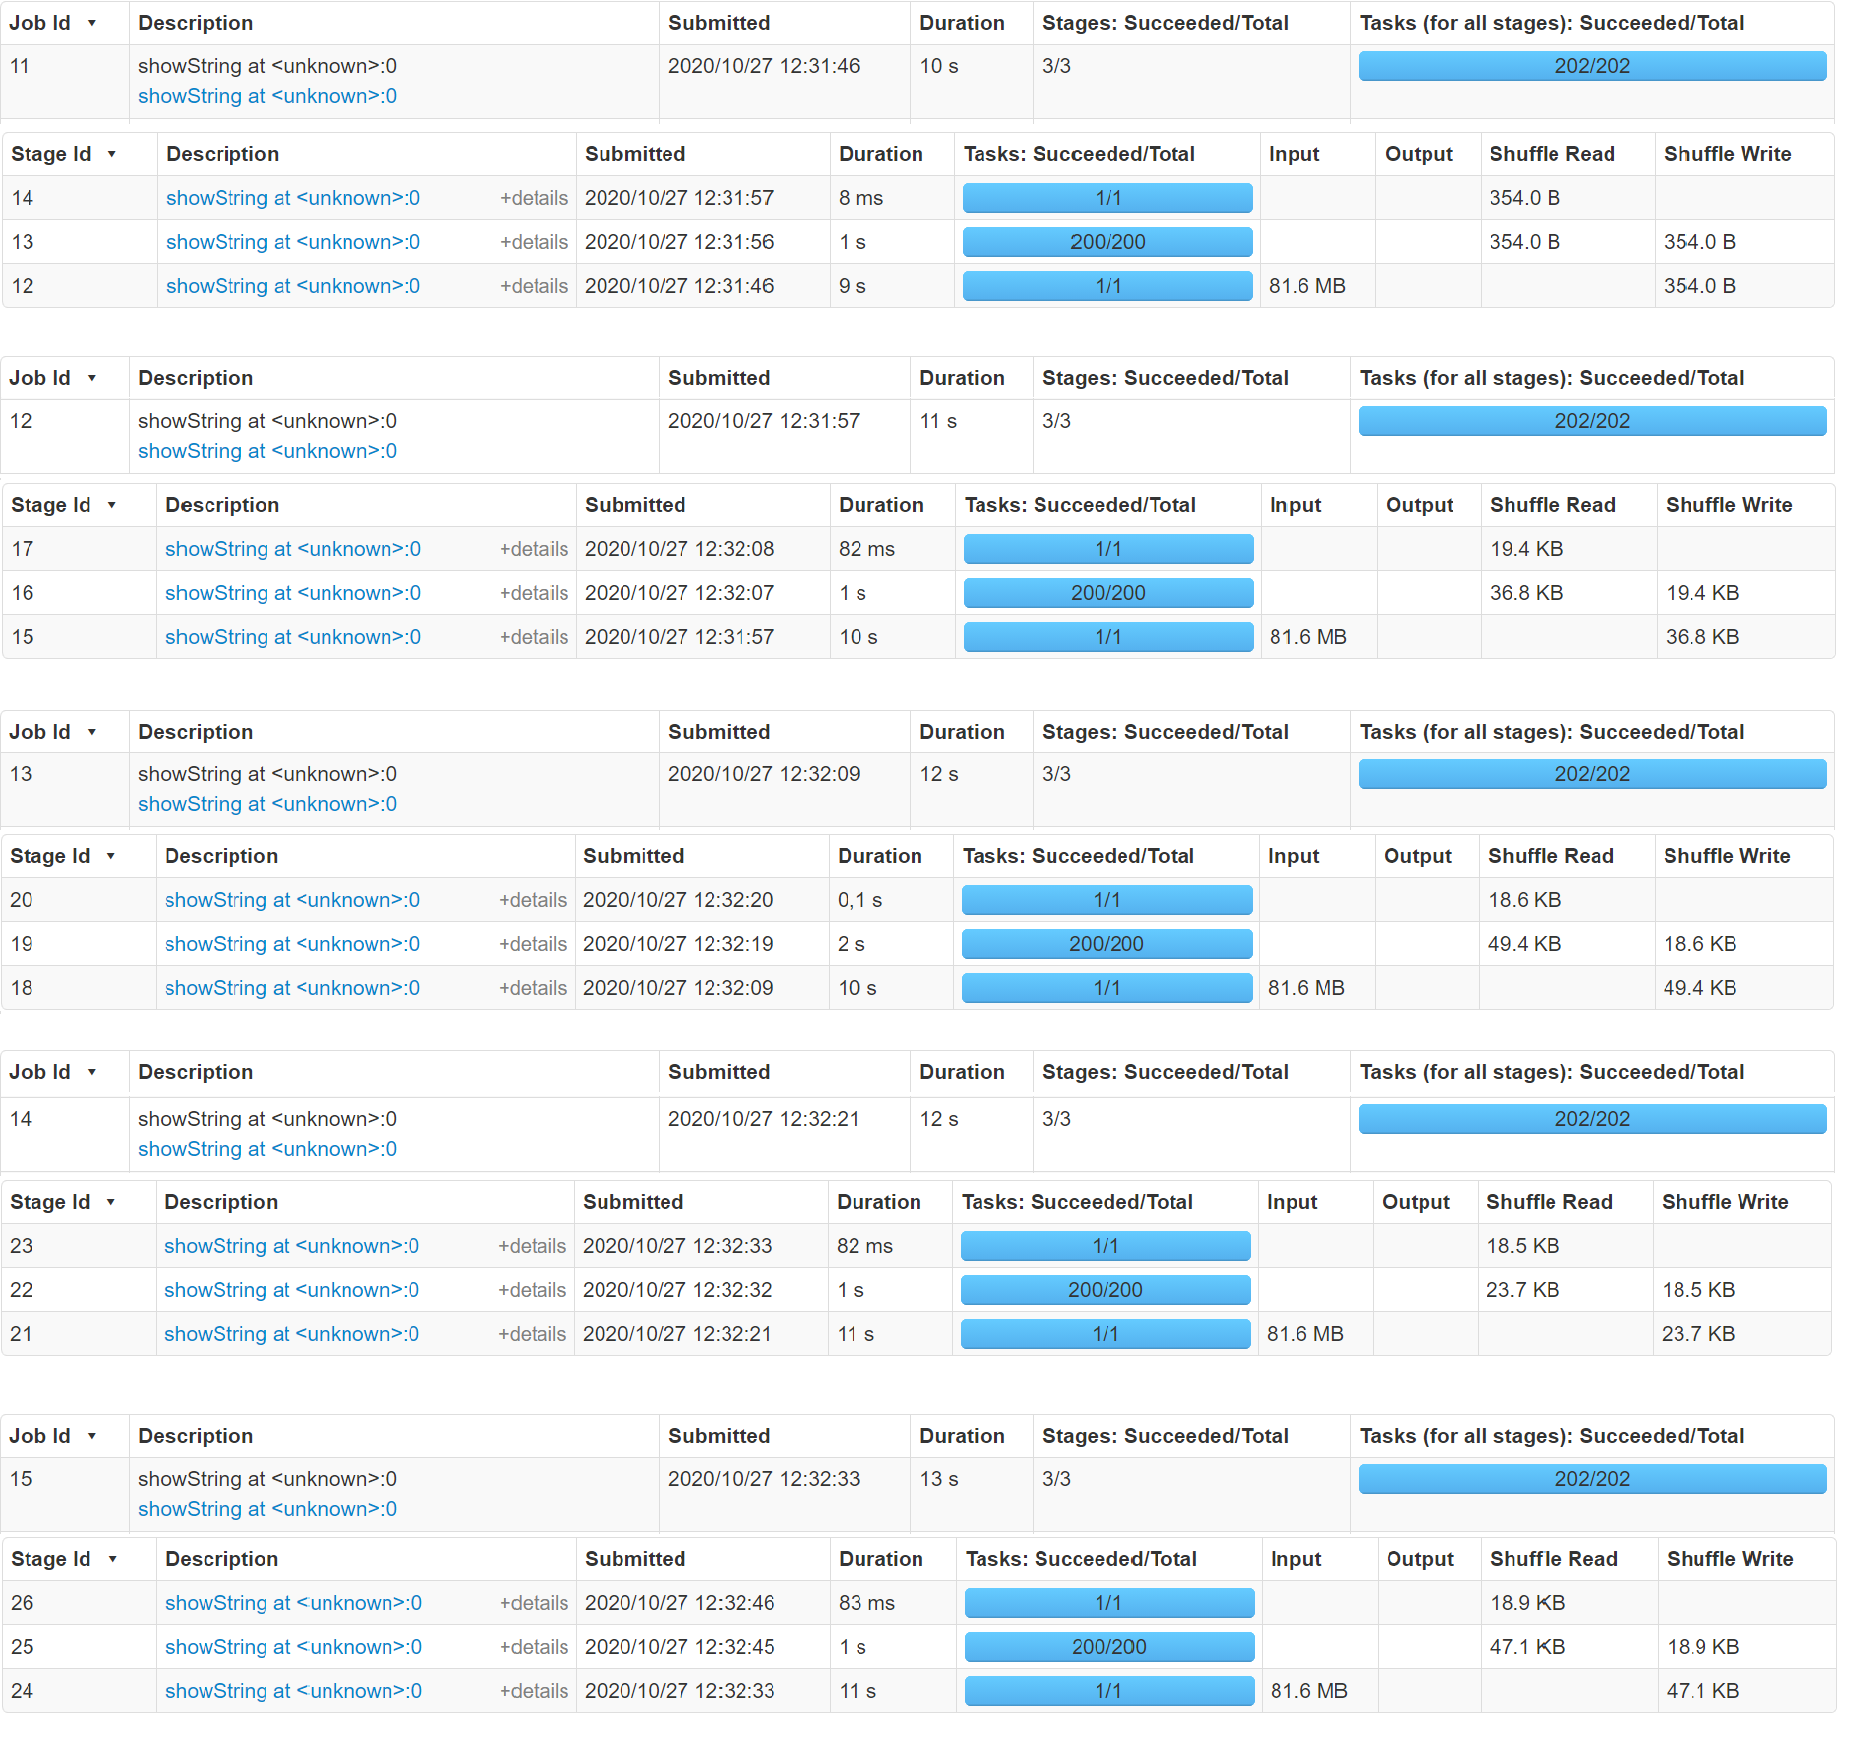

## Hottest regions with the most PU and DO

In this section, through a query with SQL, the zones with the highest activity in terms of PU, DO and PU + DO are obtained, being able to observe the Manhattan domain in the dataset.

After that, these results are shown graphically on the map previously shown.

Finally, a similar query is performed but this time on boroughs and they are displayed graphically.

In [17]:
# Views for working with SQL
df.createOrReplaceTempView("Taxis")
df_ids.createOrReplaceTempView("ZonesIDs")

In [18]:
query = """
WITH A as (
    SELECT 
        PULocationID AS LocationID,
        count('x') AS PUcount
    FROM 
        Taxis
    GROUP BY 
        PULocationID
     ),
     B as (
    SELECT 
        DOLocationID AS LocationID,
        count('x') AS DOcount
    FROM 
        Taxis
    GROUP BY 
        DOLocationID
     )
SELECT 
    LocationID,
    PUcount,
    DOcount,
    PUcount + DOcount as Total,
    Zone,
    Borough
FROM 
    A
NATURAL JOIN
    B
NATURAL JOIN
    ZonesIDs
ORDER BY
    Total DESC
"""

moves = spark.sql(query)
moves.show(10)

+----------+-------+-------+-----+--------------------+---------+
|LocationID|PUcount|DOcount|Total|                Zone|  Borough|
+----------+-------+-------+-----+--------------------+---------+
|        79|  40600|  30449|71049|        East Village|Manhattan|
|       230|  34125|  30730|64855|Times Sq/Theatre ...|Manhattan|
|        48|  33041|  29109|62150|        Clinton East|Manhattan|
|       186|  32669|  26905|59574|Penn Station/Madi...|Manhattan|
|       161|  29079|  27938|57017|      Midtown Center|Manhattan|
|       170|  27999|  28741|56740|         Murray Hill|Manhattan|
|       234|  30279|  24672|54951|            Union Sq|Manhattan|
|       236|  26533|  27548|54081|Upper East Side N...|Manhattan|
|       237|  28053|  24526|52579|Upper East Side S...|Manhattan|
|       162|  26399|  25692|52091|        Midtown East|Manhattan|
+----------+-------+-------+-----+--------------------+---------+
only showing top 10 rows



**Results of execution in http://localhost:4040/jobs/**:

This part involves two jobs, one with one stage and another with six, as shown below:

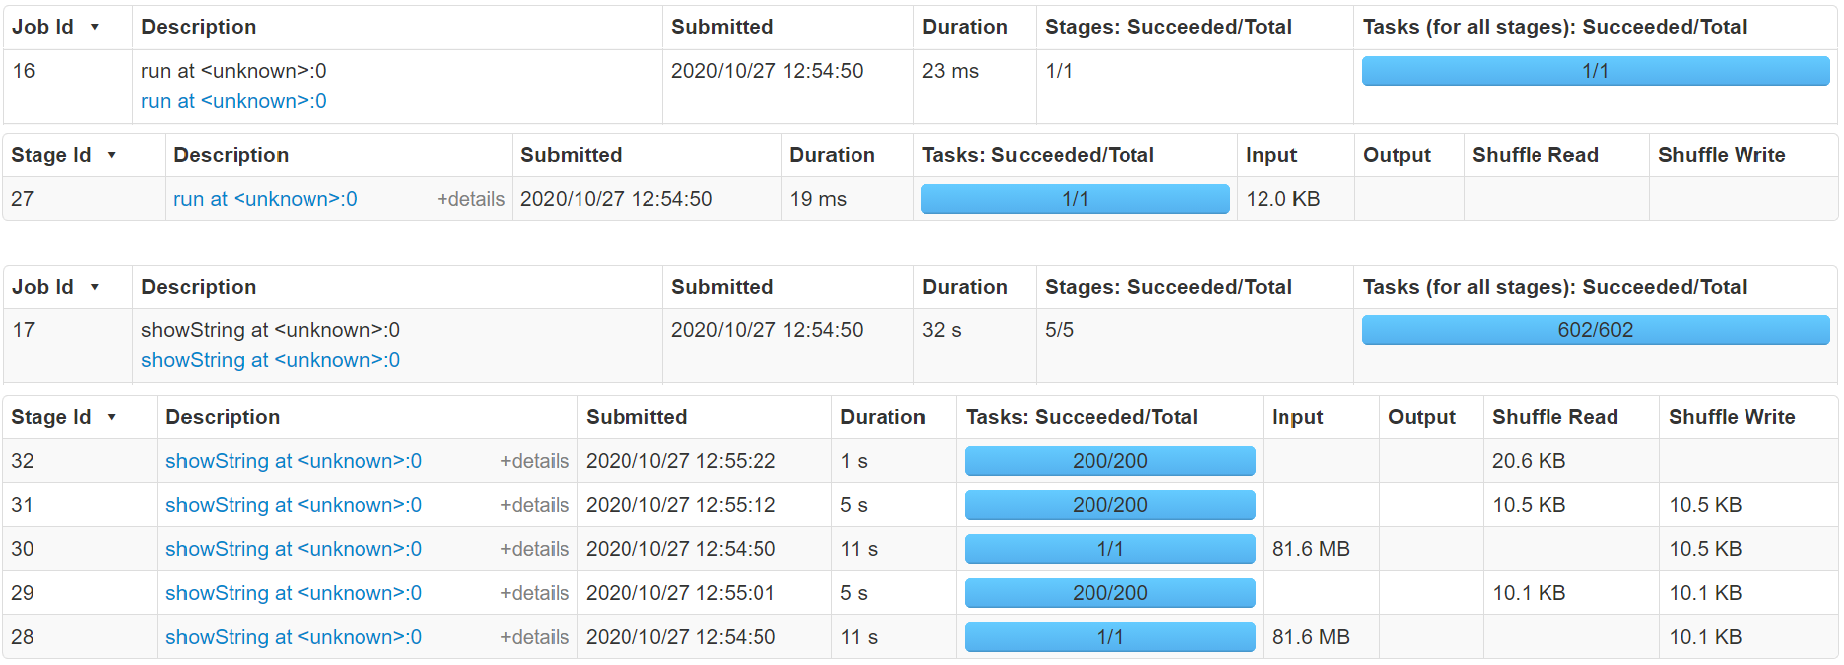

In [19]:
moves_pd = moves.toPandas()
moves.createOrReplaceTempView("Moves")

merged_df=df_places.merge(moves_pd, left_on='LocationID', right_on='LocationID')

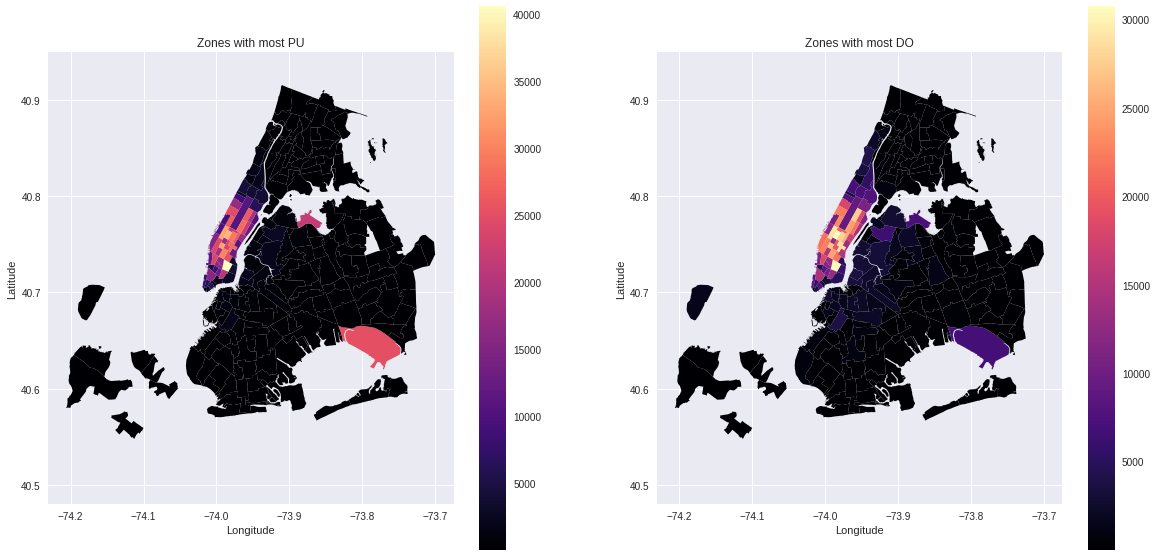

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax = plt.subplot(1, 2, 1)
ax = merged_df.plot(column='PUcount', cmap='magma', ax=ax, legend=True)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Zones with most PU')

ax = plt.subplot(1, 2, 2)
ax = merged_df.plot(column='DOcount', cmap='magma', ax=ax, legend=True)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Zones with most DO')

plt.show()

In [21]:
query = """
SELECT 
    Borough,
    sum(PUcount) as PUcount,
    sum(DOcount) as DOcount,
    sum(Total) as Total
FROM 
    Moves
GROUP BY
    Borough
ORDER BY
    Total DESC
"""

moves_b = spark.sql(query)
moves_b.show()

+-------------+-------+-------+-------+
|      Borough|PUcount|DOcount|  Total|
+-------------+-------+-------+-------+
|    Manhattan| 863077| 831978|1695055|
|       Queens|  59962|  49482| 109444|
|     Brooklyn|  19578|  52813|  72391|
|        Bronx|   1376|   7775|   9151|
|          EWR|     21|   1547|   1568|
|Staten Island|      9|     83|     92|
+-------------+-------+-------+-------+



In [22]:
moves_b_pd = moves_b.toPandas()
merged_b_df=df_places.merge(moves_b_pd, left_on='borough', right_on='Borough')

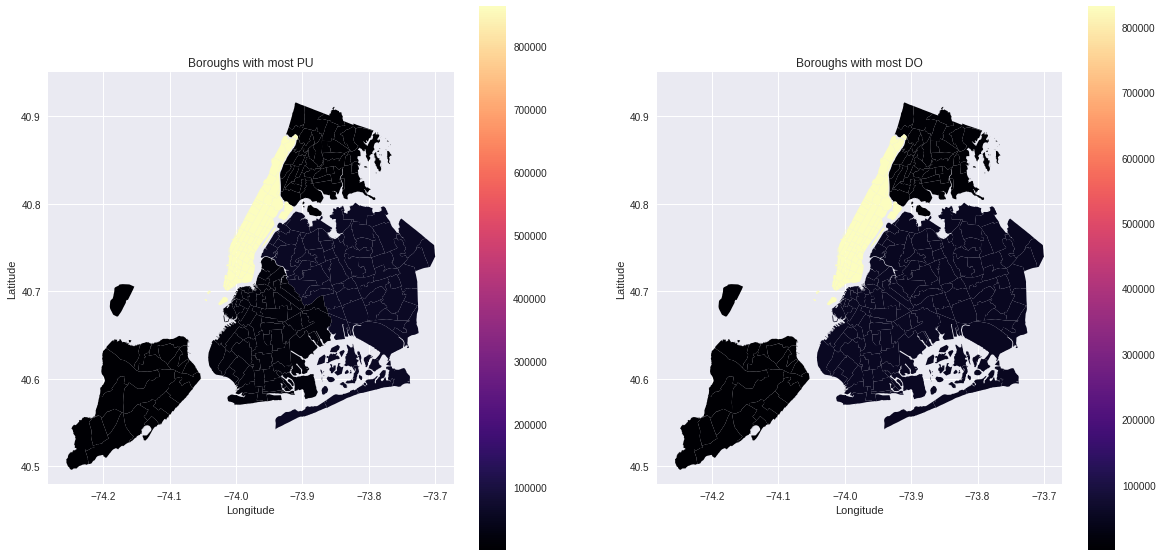

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax = plt.subplot(1, 2, 1)
ax = merged_b_df.plot(column='PUcount', cmap='magma', ax=ax, legend=True)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Boroughs with most PU')

ax = plt.subplot(1, 2, 2)
ax = merged_b_df.plot(column='DOcount', cmap='magma', ax=ax, legend=True)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Boroughs with most DO')

plt.show()

## Most common taxi trips

This section seeks to graphically represent those routes most requested by users. The following is the required SQL query and the six most common paths. Finally, a table is shown containing the ten most frequent trips by boroughs.

In [24]:
query = """
WITH A AS(
    SELECT 
        PULocationID,
        DOLocationID,
        count('x') as Count
    FROM  
        Taxis
    GROUP BY
        PULocationID,
        DOLocationID
    ORDER BY 
        Count DESC
    )
SELECT 
    PULocationID,
    t1.Zone as PUZone,
    t1.Borough PUBorough,
    DOLocationID,
    t2.Zone as DOZone,
    t2.Borough DOBorough,
    Count
FROM
    A
INNER JOIN
    ZonesIDs as t1 ON A.PULocationID = t1.LocationID
INNER JOIN
    ZonesIDs as t2 ON A.DOLocationID = t2.LocationID
"""
trips = spark.sql(query)
trips.show(10)

+------------+--------------------+---------+------------+--------------------+---------+-----+
|PULocationID|              PUZone|PUBorough|DOLocationID|              DOZone|DOBorough|Count|
+------------+--------------------+---------+------------+--------------------+---------+-----+
|         237|Upper East Side S...|Manhattan|         236|Upper East Side N...|Manhattan| 3426|
|         236|Upper East Side N...|Manhattan|         236|Upper East Side N...|Manhattan| 3121|
|         236|Upper East Side N...|Manhattan|         237|Upper East Side S...|Manhattan| 3002|
|         230|Times Sq/Theatre ...|Manhattan|         246|West Chelsea/Huds...|Manhattan| 2938|
|          79|        East Village|Manhattan|          79|        East Village|Manhattan| 2808|
|         237|Upper East Side S...|Manhattan|         237|Upper East Side S...|Manhattan| 2691|
|         239|Upper West Side S...|Manhattan|         142| Lincoln Square East|Manhattan| 2590|
|         239|Upper West Side S...|Manha

**Results of execution in http://localhost:4040/jobs/**:

This part involves three jobs with one, two and two stages respectively, as shown below:

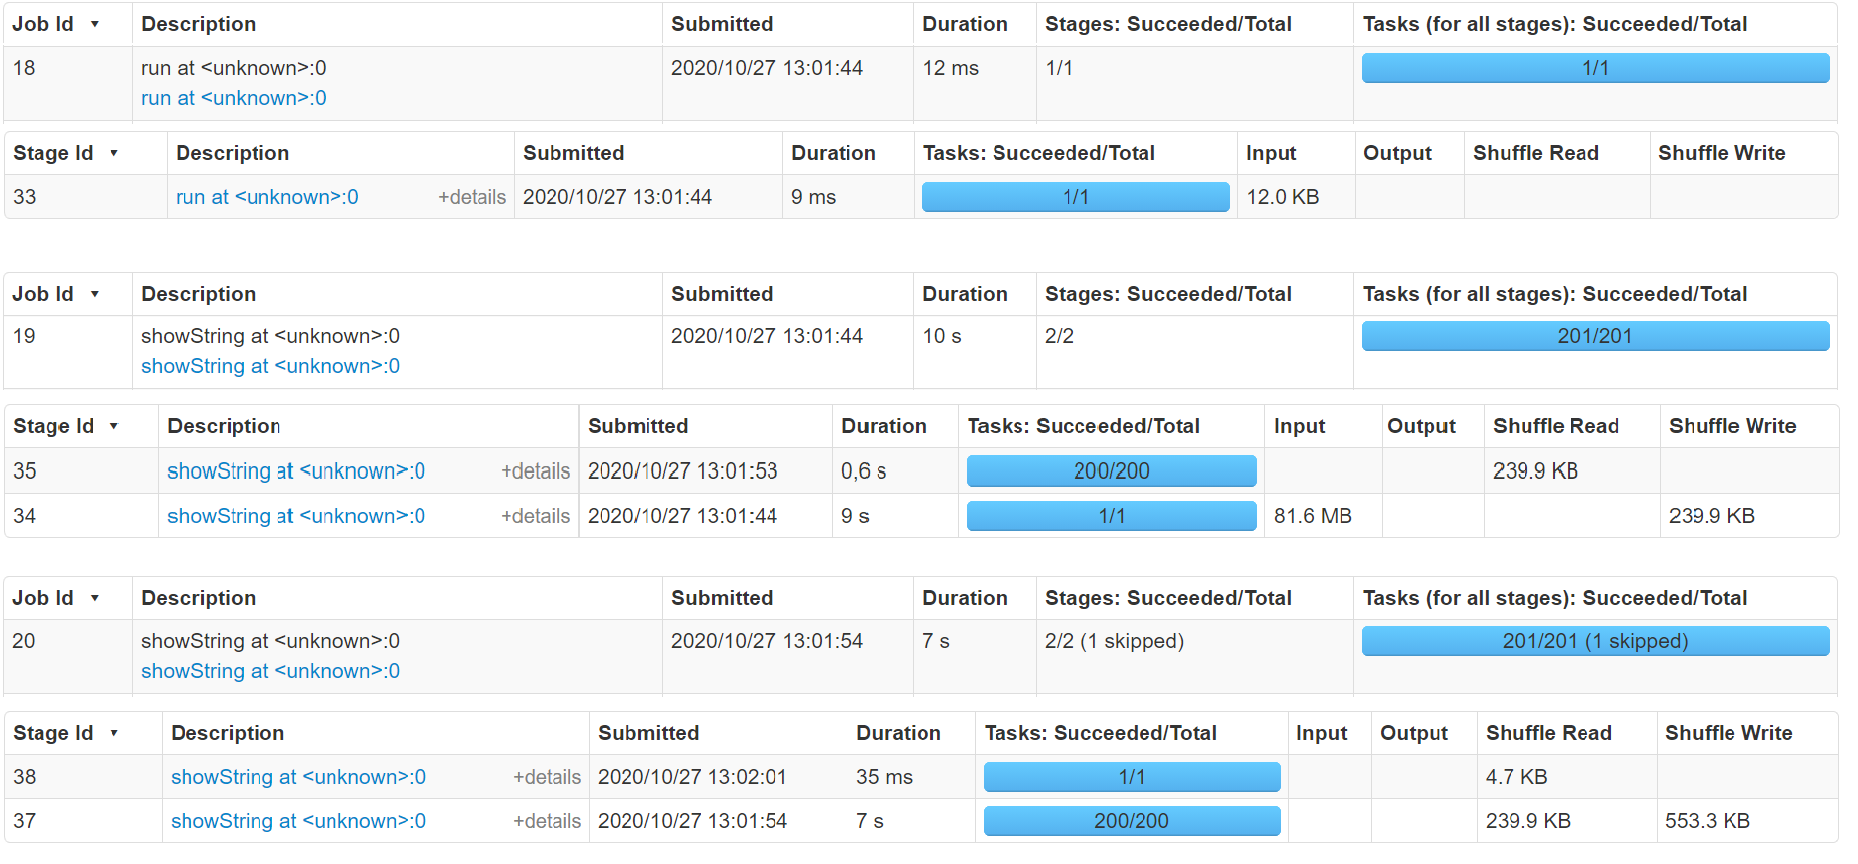

In [ ]:
trips_pd = trips.toPandas()

common1 = df_places.copy(deep=True)
common1['map'] = 0
common1['map'][trips_pd['PULocationID'][0]]=1
common1['map'][trips_pd['DOLocationID'][0]]=-1 

common2 = df_places.copy(deep=True)
common2['map'] = 0
common2['map'][trips_pd['PULocationID'][1]]=1
common2['map'][trips_pd['DOLocationID'][1]]=-1 

common3 = df_places.copy(deep=True)
common3['map'] = 0
common3['map'][trips_pd['PULocationID'][2]]=1
common3['map'][trips_pd['DOLocationID'][2]]=-1 

common4 = df_places.copy(deep=True)
common4['map'] = 0
common4['map'][trips_pd['PULocationID'][3]]=1
common4['map'][trips_pd['DOLocationID'][3]]=-1 

common5 = df_places.copy(deep=True)
common5['map'] = 0
common5['map'][trips_pd['PULocationID'][4]]=1
common5['map'][trips_pd['DOLocationID'][4]]=-1 

common6 = df_places.copy(deep=True)
common6['map'] = 0
common6['map'][trips_pd['PULocationID'][5]]=1
common6['map'][trips_pd['DOLocationID'][5]]=-1 

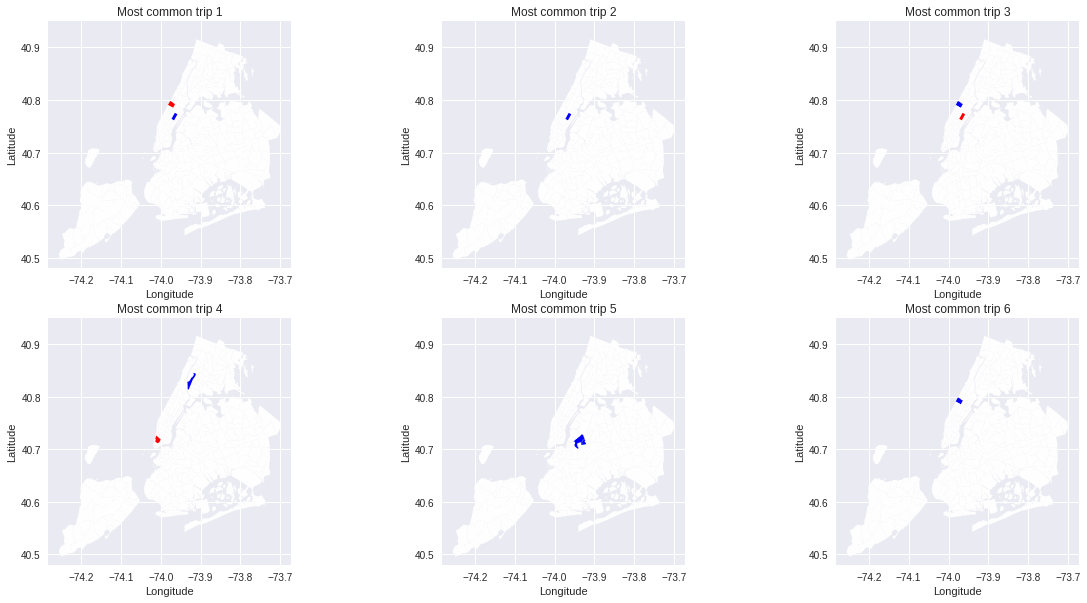

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
ax = plt.subplot(2, 3, 1)
ax = common1.plot(column='map', cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Most common trip 1')

ax = plt.subplot(2, 3, 2)
ax = common2.plot(column='map', cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Most common trip 2')

ax = plt.subplot(2, 3, 3)
ax = common3.plot(column='map', cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Most common trip 3')

ax = plt.subplot(2, 3, 4)
ax = common4.plot(column='map', cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Most common trip 4')

ax = plt.subplot(2, 3, 5)
ax = common5.plot(column='map', cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Most common trip 5')

ax = plt.subplot(2, 3, 6)
ax = common6.plot(column='map', cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_ylim([40.48, 40.95])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Most common trip 6')

plt.show()

In [27]:
trips.createOrReplaceTempView("Trips")

In [28]:
query = """
SELECT 
    PUBorough,
    DOBorough,
    sum(Count) as Count
FROM 
    Trips
GROUP BY
    PUBorough,
    DOBorough
ORDER BY
    Count DESC
"""
trips_b = spark.sql(query)
trips_b.show(10)

+---------+---------+------+
|PUBorough|DOBorough| Count|
+---------+---------+------+
|Manhattan|Manhattan|793584|
|   Queens|Manhattan| 32786|
|Manhattan|   Queens| 31262|
|Manhattan| Brooklyn| 30768|
|   Queens|   Queens| 16979|
| Brooklyn| Brooklyn| 12948|
|   Queens| Brooklyn|  9080|
|Manhattan|    Bronx|  5841|
| Brooklyn|Manhattan|  5196|
|Manhattan|      EWR|  1487|
+---------+---------+------+
only showing top 10 rows



**Results of execution in http://localhost:4040/jobs/**:

This part involves three jobs with one, two and three stages, as shown below:

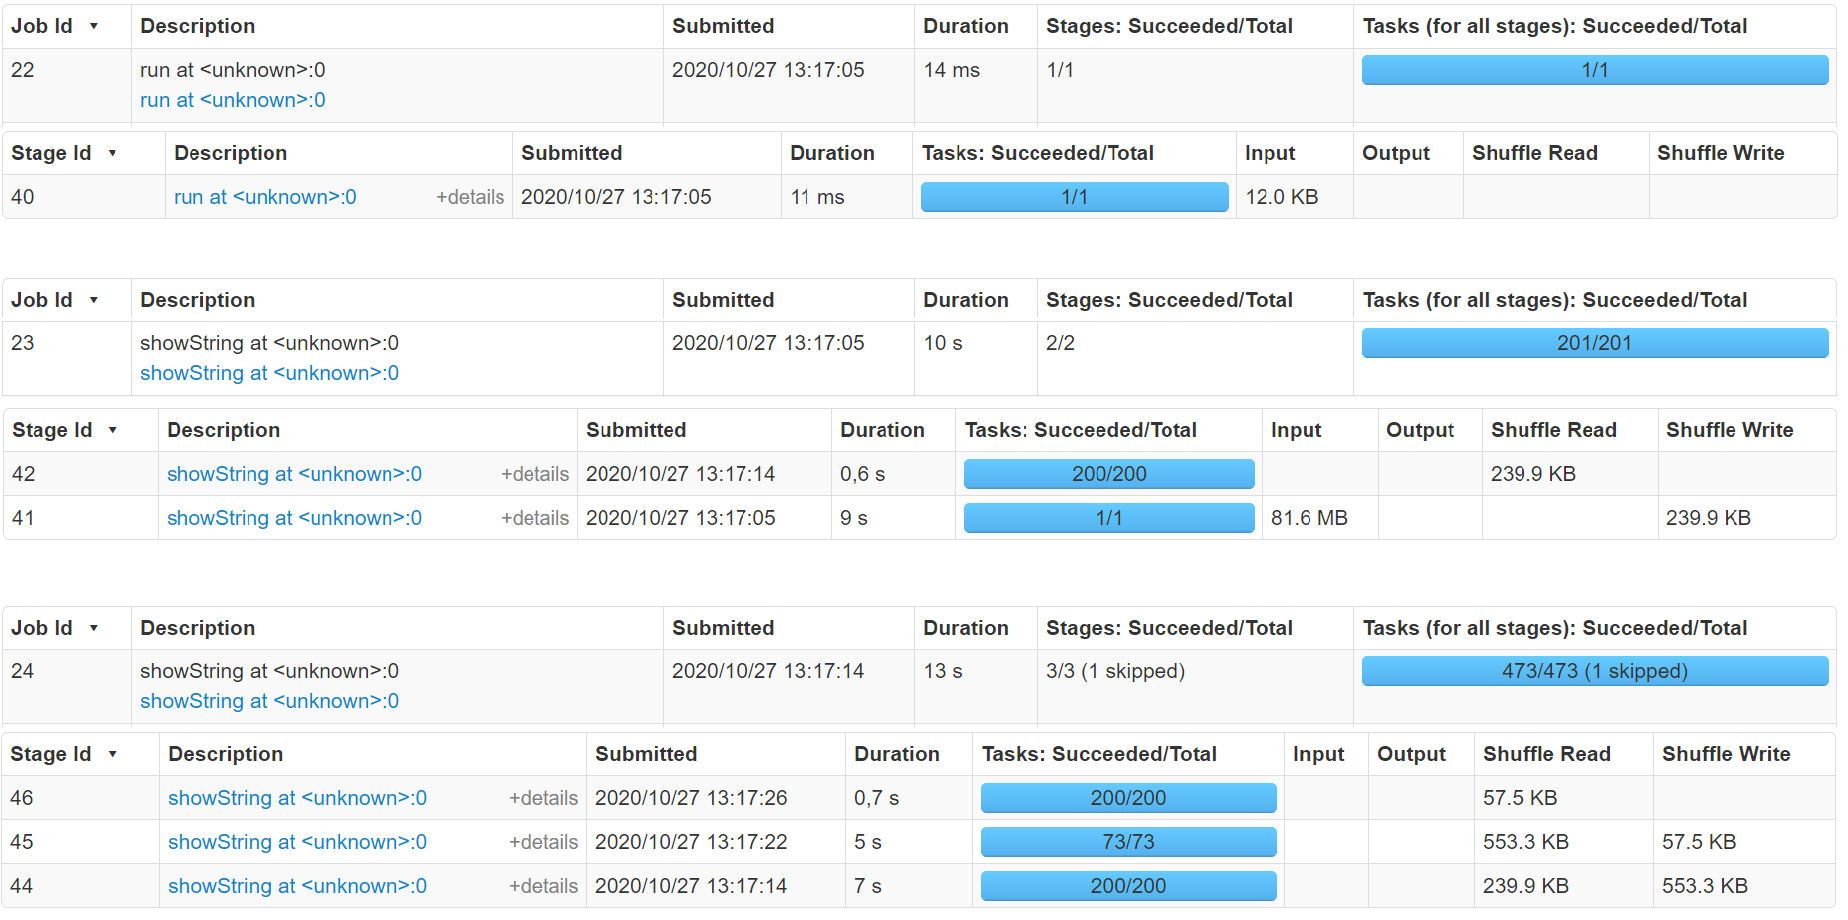

## Neighborhood interaction between Top 10 zones in terms of PU and DO

In this section, by virtue of the result of section X where it is shown that zone 79 is the one with the highest value in pick-ups + drop-offs, we proceed to answer the following question based on the ten zones with most DO+PU : How are the travelers who leave the most requested area divided among this ten areas?

In [29]:
intermediate = df_correlation.where(df_correlation['Pick_up_ID'].isin('79'))
                                                                                                                         
top10_locations_79 = intermediate.where(intermediate['Drop_off_ID'].isin('79', '230', 
                                                                  '48', '186', 
                                                                  '161', '170', 
                                                                  '234', '236', 
                                                                  '237', '162')).select(intermediate['Drop_off_ID'])

zone_79 = top10_locations_79.select('Drop_off_ID').rdd.flatMap(lambda y: y).collect()

# Map
mapping2 = map((lambda y : (y, 1)), zone_79)

# Shuffle
sorted_map2 = sorted(mapping2)

# Reduce: 
groups2 = groupby(sorted_map2, lambda s:s[0])
result2 = map(lambda lam: (lam[0], reduce(lambda y, z: y + z, map(lambda s:s[1], lam[1]))), groups2)
zone_79_list=list(result2)

**Results of execution in http://localhost:4040/jobs/**:

This part involves one job with one stage, as shown below:

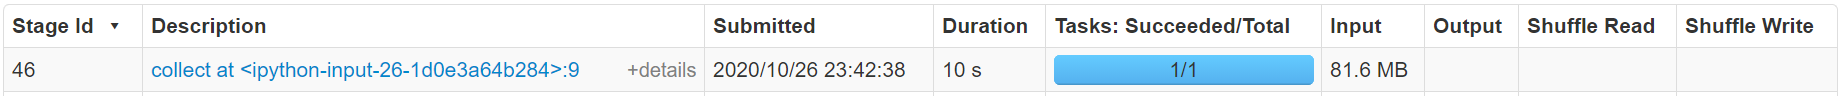

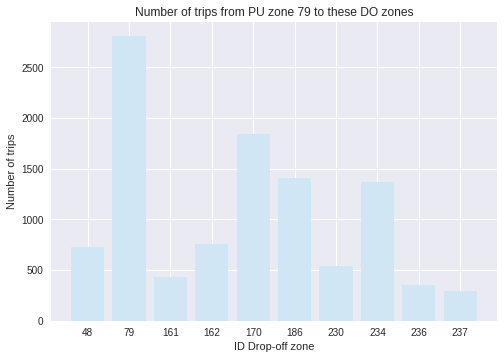

In [30]:
# Bar plot: Interaction between Neighborhoods
fig, ax = plt.subplots()
ax.bar(range(len(zone_79_list)), [t[1] for t in zone_79_list]  , align="center", color='#d0e6f5')
ax.set_xticks(range(len(zone_79_list)))
ax.set_xticklabels(['48', '79', '161', '162', '170', '186', '230', '234', '236', '237'],)
ax.set_title('Number of trips from PU zone 79 to these DO zones')
ax.set_ylabel('Number of trips')
ax.set_xlabel('ID Drop-off zone')
plt.show()

## As a function of PU hour, plot relevant information: 

Number of trips, mean distance, duration, speed, tips/km and price/km. 

The graphs are made with a pandas data frame. 



In [31]:
df_PUhour = df_intermediate.withColumn('PU hour', substring(df_intermediate['pickup_date'], 12, 2)).withColumn('speed_km_h', df_intermediate['distance_km']/df_intermediate['time_min']*60).withColumn('tip_km', df_intermediate['tip_dollars']/df_intermediate['distance_km']).withColumn('price_km_notips', (df_intermediate['journey_price']-df_intermediate['tip_dollars'])/df_intermediate['distance_km'])

df_PUhour_final = df_PUhour.groupBy('PU hour').agg(count('distance_km').alias('Number of journeys'),mean('distance_km').alias('Average distance in km'), mean('time_min').alias('Average duration in mins'), mean('speed_km_h').alias('Average speed in km/h'),mean('tip_km').alias('Average tip/km'),mean('price_km_notips').alias('Average price without tips/km')).sort(asc("PU hour"))

df_PUhour_final.show(24)

+-------+------------------+----------------------+------------------------+---------------------+-------------------+-----------------------------+
|PU hour|Number of journeys|Average distance in km|Average duration in mins|Average speed in km/h|     Average tip/km|Average price without tips/km|
+-------+------------------+----------------------+------------------------+---------------------+-------------------+-----------------------------+
|     00|             41338|     4.909660777178484|      13.483517183543748|   23.620427624478943| 0.4684537484164771|            4.449087460548073|
|     01|             48882|     4.832835311738584|      13.182953848042244|   24.021320728014192|0.47555004923254696|            4.100115445873162|
|     02|             35337|     5.144182874443306|      12.836413674052654|   25.346093825090364| 0.4488902244447106|             4.31512501937168|
|     03|             28298|     5.437847710078465|       12.59219320564468|    27.61392869484463| 0.59172

**Results of execution in http://localhost:4040/jobs/**:

This part involves one job with two stages, as shown below:

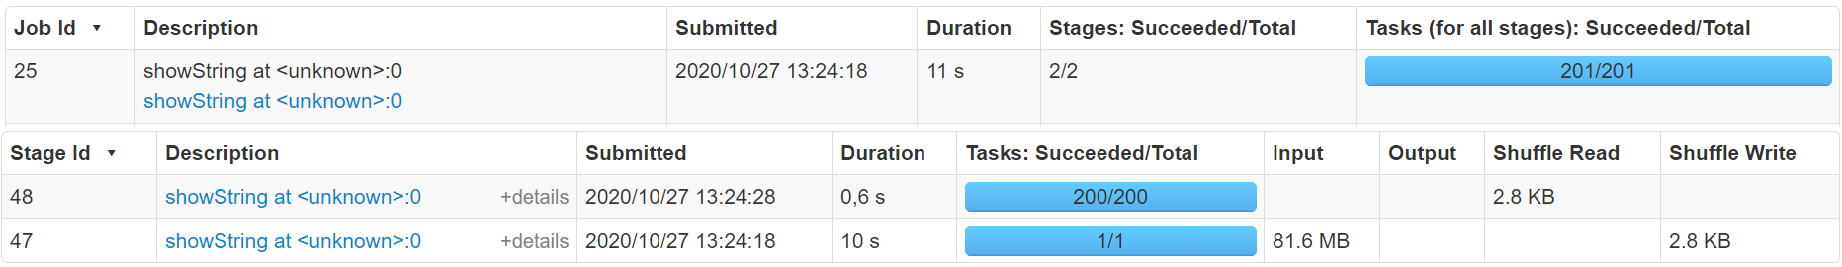

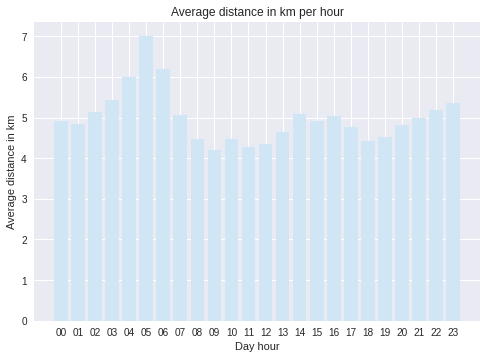

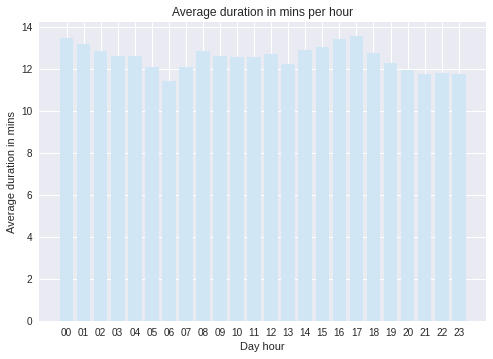

In [32]:
plot_df = df_PUhour_final.toPandas()

plt.bar(plot_df['PU hour'],plot_df['Average distance in km'], color='#d0e6f5')
plt.xlabel('Day hour')
plt.ylabel('Average distance in km')
plt.title('Average distance in km per hour')
plt.show()

plt.bar(plot_df['PU hour'],plot_df['Average duration in mins'], color='#d0e6f5')
plt.xlabel('Day hour')
plt.ylabel('Average duration in mins')
plt.title('Average duration in mins per hour')
plt.show()

There is a greater demand for long journeys at dawn. 

The rest of the day the average distance is similar, with slight increases at noon and at midnight.

According to the average duration, there are no large fluctuations, with almost all time bands between 12 and 14 minutes.

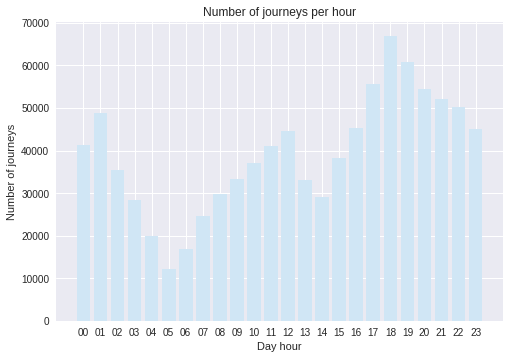

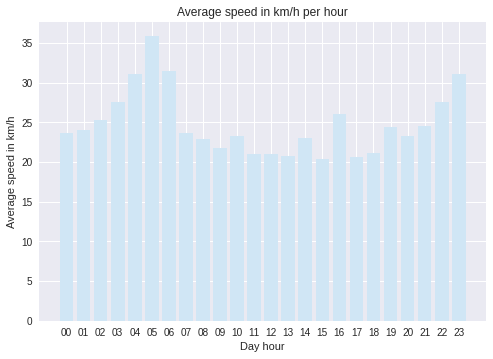

In [33]:
plt.bar(plot_df['PU hour'],plot_df['Number of journeys'], color='#d0e6f5')
plt.xlabel('Day hour')
plt.ylabel('Number of journeys')
plt.title('Number of journeys per hour')
plt.show()

plt.bar(plot_df['PU hour'],plot_df['Average speed in km/h'], color='#d0e6f5')
plt.xlabel('Day hour')
plt.ylabel('Average speed in km/h')
plt.title('Average speed in km/h per hour')
plt.show()

In this pair of graphs, more variable results are observed. 

Considering that the dataset has been trimmed, a behavior consistent with economic activity is observed, with demand growing as the working day begins, declining at noon and rising again in the afternoon.

The average speed is substantially higher in the early morning, a result influenced by the absence of traffic.



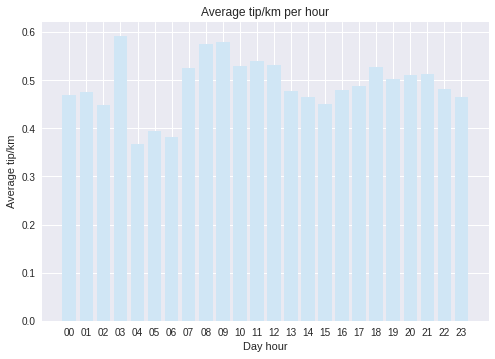

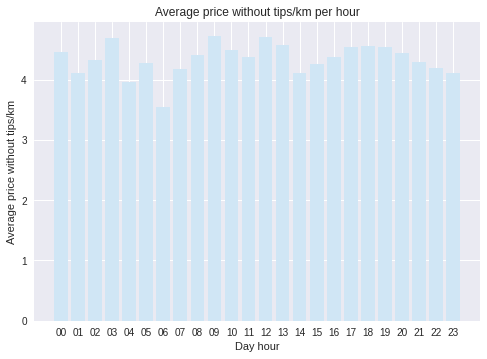

In [34]:
plt.bar(plot_df['PU hour'],plot_df['Average tip/km'], color='#d0e6f5')
plt.xlabel('Day hour')
plt.ylabel('Average tip/km')
plt.title('Average tip/km per hour')
plt.show()

plt.bar(plot_df['PU hour'],plot_df['Average price without tips/km'], color='#d0e6f5')
plt.xlabel('Day hour')
plt.ylabel('Average price without tips/km')
plt.title('Average price without tips/km per hour')
plt.show()

Finally, the graphs of average tips per km and average trips without tip per km are shown.

It is observed how people tend to be more generous early in the day.